In [84]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


%matplotlib inline
import matplotlib.pyplot as plt



# Early Stop via Prediction for Hyperparameter Tuning

## Introduction

DNN model training takes time. In hyperparameter tuning (i.e., finding the best values for some hyperparameters for a DNN model), we would need to train the DNN model repeatedly on each of the hyperparameter values and run the test. It would take even more time.

The objective of this project is to see whether we can predict the final accuracy of a DNN model for given hyperparameters values, without training the DNN model completely. In another word, can we tell how good the hyperparamter values are by just observing the results in the first small number of training eporches of the DNN model? If we can do that, it can save a lot of time in hyperparameter tuning. 
 
The method we want to try in this project is to build a Machine Learning model (called accModel) to make the prediction. For a given DNN X and a set of k hyperparameters H=<h1, h2, ..., hk> to tune, the input to the accModel includes (i) a sample hyperparameter vector Hi=<h1i, h2i, ..., hki>, where hki is the sample value of the kth hyperparameter; (ii) the observed training and validation loss values and accuracy values in the first E eporchs; (iii) a positive integer M (M>E). The output of the accModel is the predicted validation accuracy of DNN X after M eporchs of training with Hi as the hyperparameter vector. 

## Dataset

The provided dataset were obtained by training **<u>CifarNet</u>** on the **Cifar-10** dataset. *CifarNet* contains two convolutional layers. There are two hyperparameters, ***L*** and ***H***, at each of the two convolutional layers. So there are four hyperparameters in the hyperparameter vector of *CifarNet*: <L1, H1, L2, H2>. 

* HP_space.csv: the sampled hyperparameter vector values. 

* train_loss.csv: the **training loss values**. The file is organized as follows:

  - Each row gives the observations on *CifarNet* on one sampled hyperparameter vector.  
  - The first 4 columns indicate the hyperparameter vector value (it's the same as in `HP_space.csv`). 
  - The following columns show the training losses. 150 epochs are recorded, and each epoch contains 50 mini-batches.

* eval_loss.csv: the **validation loss values** of *CifarNet*. It is in a similar format as `train_loss.csv`, but reports only one loss in each epoch.

* eval_acc.csv: the **validation accuracies** of *CifarNet*. It is in a similar format as `train_loss.csv`, but reports only one accuracy in each epoch.

* dataPartition.txt: the samples (i.e., line numbers in the above data files) to be used as training dataset, validation dataset, and test dataset for the development of accModel.

## Requirement

* Create one (or more) accModel that can achieve the objective
* Report the accuracies of the eval_acc of *CifarNet* predicted by the accModel on the test dataset in the following settings: (E=5, M=150), (E=10, M=150), (E=20, M=150), (E=30, M=150), (E=60, M=150). 
* Put your code in a Github repository. Organize it well with the necessary README, stating the content of the repository, instructions on how to install and run, and any known limitations. The repository should be made easy for others to reproduce your testing results without retraining the models, and at the same, include the necessary scripts and instructions for reproducing the training process if the users want to do that. 

## Q & A:
* What to submit? 
  - A PPT file clearly explaining your results and observations, and include the github link.
* What models to use?
  - No restrictions.
* What DNN frameworks to use? 
  - TensorFlow or PyTorch





## Training

In [2]:
import pandas as pd
import numpy as np
import json

In [3]:
train = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202]
validation =  [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127, 131, 135, 139, 143, 147, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199]
test = [5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201]


In [4]:
acc_data = pd.read_csv('eval_acc.csv')
loss_data = pd.read_csv('eval_loss.csv')


In [5]:
train_data = acc_data.iloc[train]
test_data = acc_data.iloc[test]

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def scale(x):
    return scaler.fit_transform(x)

acc_data.iloc[:,0:4] = scale(acc_data.iloc[:,0:4])

In [7]:
from torch.utils.data import TensorDataset, DataLoader
def process(data,block_size,split,batch_size):
    data_split = data.iloc[split]
    #block_size = 5
    X, Y = [],[]
    for row in range(data_split.shape[0]):
        hyp = list(data_split.iloc[row,0:4])

        for i in range(4,data_split.shape[1]-block_size):
            seq = list(data_split.iloc[row,i:i+block_size+1])
            if np.isnan(seq).any():
                break
            X.append(hyp + seq[:-1])
            Y.append(seq[-1])
    #batch_size = 32
    dataset = TensorDataset(torch.Tensor(X),torch.Tensor(Y))
    return DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [8]:
test_loader = process(acc_data,5,test,32)
train_loader = process(acc_data,5,train,32)
val_loader = process(acc_data,5,validation,32)

In [9]:
import torch
import torch.nn as nn

# class MyModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MyModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 32)
#         self.fc2 = nn.Linear(32,16)
#         self.fc3 = nn.Linear(16,output_size)
    
#     def forward(self, input):
#         batch_size = input.size(0)
#         hidden = self.init_hidden(batch_size)
#         output, hidden = self.rnn(input, hidden)
#         #print(output,hidden)
#         output = nn.ReLU()(self.fc(output))
#         output = nn.ReLU()(self.fc2(output))
#         output = self.fc3(output)
#         return output
    
#     def init_hidden(self, batch_size):
#         hidden = torch.zeros(1, batch_size, self.hidden_size)  # Assuming single layer RNN
#         return hidden

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, 2,batch_first=True)
        self.fc = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,output_size)
    
    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.init_hidden(batch_size)
        output, hidden = self.rnn(input, hidden)
        #print(output,hidden)
        output = nn.ReLU()(self.fc(output))
        output = nn.ReLU()(self.fc2(output))
        output = self.fc3(output)
        return output
    
    def init_hidden(self, batch_size):
        '''
        To initialize hidden state
        '''
        hidden = torch.zeros(2, batch_size, self.hidden_size)  
        return hidden


input_size = 9
#hidden_size = 64
hidden_size = 12
output_size = 1
# sequence_length = 9
batch_size = 32  

model = MyModel(input_size, hidden_size, output_size)




In [10]:
def evaluate(data_loader,loss_function,model):
    total_loss = 0
    with torch.no_grad():
        model.eval()
        for data,target in data_loader:
            output = model(data.unsqueeze(1))
            loss = loss_function(output.squeeze(1),target.unsqueeze(1))
            total_loss+=loss.item()
        avg_loss = total_loss/len(data_loader)
        #print(f"avg loss = {total_loss/len(data_loader)}")
    return avg_loss

In [11]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))


In [12]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
#loss_function = nn.MSELoss()
loss_function = RMSELoss()
tloss_logs = []
vloss_logs = []
epochs = 100
best_loss = float('inf')
for epoch in range(epochs):
    if epoch==40:
      learning_rate = 0.0001
      optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    total_loss = 0
    for data,label in train_loader:
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))
        loss = loss_function(output.squeeze(1),label.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    avg_loss = total_loss/len(train_loader)
    print(f"avg training loss = {avg_loss}")
    tloss_logs.append(avg_loss)
    vloss = evaluate(val_loader,loss_function,model)
    print(f"avg validation loss = {vloss}")
    vloss_logs.append(vloss)
    if vloss<best_loss:
        best_loss = vloss
        torch.save(model.state_dict(),'new_best_model_rmse.pth')
        print('model checkpoint saved')
    


avg training loss = 0.059481971682264254
avg validation loss = 0.011085360509954754
model checkpoint saved
avg training loss = 0.00983529021697385
avg validation loss = 0.009739419972597895
model checkpoint saved
avg training loss = 0.009474704945766991
avg validation loss = 0.008874431291455608
model checkpoint saved
avg training loss = 0.008985737640062694
avg validation loss = 0.008398881584143323
model checkpoint saved
avg training loss = 0.008613968794080582
avg validation loss = 0.010945354487812598
avg training loss = 0.008354009656685885
avg validation loss = 0.007686650388697695
model checkpoint saved
avg training loss = 0.008005612239159726
avg validation loss = 0.008012449973989031
avg training loss = 0.007619697199417994
avg validation loss = 0.007296675340260178
model checkpoint saved
avg training loss = 0.007387537584936881
avg validation loss = 0.008652626309084342
avg training loss = 0.007630824633352049
avg validation loss = 0.007330614812918303
avg training loss = 0.0

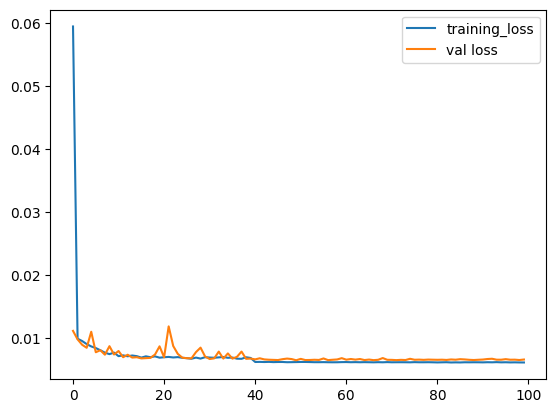

In [15]:
plt.plot(tloss_logs,label='training_loss')
plt.plot(vloss_logs,label = 'val loss')
plt.legend()


In [17]:
model.load_state_dict(torch.load('new_best_model_rmse.pth'))

<All keys matched successfully>

In [18]:
loss_function = RMSELoss()
total_loss = 0
with torch.no_grad():
    model.eval()
    for data,target in test_loader:
        output = model(data.unsqueeze(1))
        loss = loss_function(output.squeeze(1),target.unsqueeze(1))
        total_loss+=loss.item()
    print(f"avg loss = {total_loss/len(test_loader)}")
        


avg loss = 0.005883077617909294


## Inference and Evaluation

In [36]:
from sklearn.metrics import r2_score

In [ ]:
model = MyModel(9,64,1)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [ ]:
def process(data,block_size,split,batch_size):
    data_split = data.iloc[split]
    #block_size = 5
    X, Y = [],[]
    for row in range(data_split.shape[0]):
        hyp = list(data_split.iloc[row,0:4])

        for i in range(4,data_split.shape[1]-block_size):
            seq = list(data_split.iloc[row,i:i+block_size+1])
            if np.isnan(seq).any():
                break
            X.append(hyp + seq[:-1])
            Y.append(seq[-1])
    #batch_size = 32
    dataset = TensorDataset(torch.Tensor(X),torch.Tensor(Y))
    return DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [19]:
### The first 4 features are already scaled along with the rest of the dataset.
## For (E = 5, M = 150)
val_set = acc_data.iloc[validation]
test_set = acc_data.iloc[test]
task1_set = test_set.iloc[:,0:9]
fixed = torch.Tensor(task1_set.iloc[:,0:4].values)
sequence = torch.Tensor(task1_set.iloc[:,4:].values)

In [24]:
val_set = acc_data.iloc[validation]
test_set = acc_data.iloc[test]
## Dropped rows containing NAN values for the final results

test_set = test_set.dropna()
task1_set = test_set.iloc[:,0:9]
fixed = torch.Tensor(task1_set.iloc[:,0:4].values)
sequence = torch.Tensor(task1_set.iloc[:,4:].values)

In [21]:
fixed = torch.Tensor(task1_set.iloc[:,0:4].values)
sequence = torch.Tensor(task1_set.iloc[:,4:].values)
model.eval()
for i in range(6,151):
    new_pred = model(torch.cat((fixed.unsqueeze(1),sequence.unsqueeze(1)),dim = 2))
    sequence = torch.cat((sequence[:,1:],new_pred.squeeze(2)),dim = 1)

In [22]:
test_set.iloc[:,-1].values

array([0.7308, 0.7304, 0.686 , 0.7098, 0.7171, 0.6559, 0.6882, 0.7168,
       0.644 , 0.6717, 0.6993, 0.609 , 0.6638, 0.7121, 0.6486, 0.7061,
       0.7367, 0.6096, 0.7003, 0.7233, 0.5712, 0.7147, 0.5914, 0.6124,
       0.6924, 0.7518, 0.7756, 0.6809, 0.7509, 0.781 , 0.6404, 0.763 ,
       0.7825, 0.6269, 0.7568, 0.7859, 0.6031, 0.7474, 0.7809, 0.6034,
       0.7005, 0.7755, 0.6209, 0.7548, 0.7784, 0.588 , 0.5451, 0.6305,
       0.6359])

In [23]:
new_pred.squeeze(1).squeeze(1)

tensor([0.7312, 0.7441, 0.6867, 0.7278, 0.7425, 0.6576, 0.7083, 0.7338, 0.6507,
        0.6918, 0.7242, 0.6171, 0.6679, 0.7065, 0.5814, 0.7180, 0.7348, 0.5813,
        0.7183, 0.7353, 0.5808, 0.7184, 0.5783, 0.5774, 0.7112, 0.7386, 0.7622,
        0.7144, 0.7391, 0.7692, 0.7153, 0.7406, 0.7873, 0.7160, 0.7415, 0.7901,
        0.7189, 0.7438, 0.7918, 0.7159, 0.7446, 0.7928, 0.5033, 0.7419, 0.7938,
        0.5831, 0.5702, 0.6096, 0.5836], grad_fn=<SqueezeBackward1>)

In [ ]:
loss_function(new_pred.squeeze(1),torch.Tensor(test_set.iloc[:,-1].values).unsqueeze(1))

tensor(0.0370, grad_fn=<SqrtBackward0>)

In [32]:
#(E=10,m=150) task 2
task2_set = test_set.iloc[:,0:14]
fixed = torch.Tensor(task2_set.iloc[:,0:4].values)
sequence = torch.Tensor(task2_set.iloc[:,-5:].values)
model.eval()
for i in range(11,151):
    new_pred = model(torch.cat((fixed.unsqueeze(1),sequence.unsqueeze(1)),dim = 2))
    sequence = torch.cat((sequence[:,1:],new_pred.squeeze(2)),dim = 1)

In [33]:
print(test_set.iloc[:,-1].values)#, new_pred.transpose()

[0.7308 0.7304 0.686  0.7098 0.7171 0.6559 0.6882 0.7168 0.644  0.6717
 0.6993 0.609  0.6638 0.7121 0.6486 0.7061 0.7367 0.6096 0.7003 0.7233
 0.5712 0.7147 0.5914 0.6124 0.6924 0.7518 0.7756 0.6809 0.7509 0.781
 0.6404 0.763  0.7825 0.6269 0.7568 0.7859 0.6031 0.7474 0.7809 0.6034
 0.7005 0.7755 0.6209 0.7548 0.7784 0.588  0.5451 0.6305 0.6359]


In [34]:
new_pred.squeeze(1).squeeze(1)

tensor([0.7312, 0.7441, 0.6882, 0.7278, 0.7425, 0.6576, 0.7084, 0.7338, 0.6507,
        0.6918, 0.7242, 0.6171, 0.6679, 0.7065, 0.6557, 0.7183, 0.7348, 0.5813,
        0.7186, 0.7353, 0.5808, 0.7189, 0.5783, 0.5774, 0.7149, 0.7386, 0.7622,
        0.7160, 0.7391, 0.7692, 0.7166, 0.7406, 0.7873, 0.7165, 0.7415, 0.7901,
        0.7190, 0.7438, 0.7918, 0.7158, 0.7446, 0.7928, 0.5074, 0.7419, 0.7938,
        0.5831, 0.5702, 0.6096, 0.5836], grad_fn=<SqueezeBackward1>)

In [35]:
loss_function(new_pred.squeeze(1),torch.Tensor(test_set.iloc[:,-1].values).unsqueeze(1))

tensor(0.0374, grad_fn=<SqrtBackward0>)

In [37]:
r2_score(new_pred.squeeze(1).detach().numpy(),test_set.iloc[:,-1].values)

0.7099658147860815

In [48]:
#(E=20,m=150) task 2
task3_set = test_set.iloc[:,0:24]
fixed = torch.Tensor(task3_set.iloc[:,0:4].values)
sequence = torch.Tensor(task3_set.iloc[:,-5:].values)
model.eval()
for i in range(21,151):
    new_pred = model(torch.cat((fixed.unsqueeze(1),sequence.unsqueeze(1)),dim = 2))
    sequence = torch.cat((sequence[:,1:],new_pred.squeeze(2)),dim = 1)

In [49]:
new_pred.squeeze(1).squeeze(1)

tensor([0.7314, 0.7441, 0.6940, 0.7279, 0.7425, 0.6576, 0.7085, 0.7338, 0.6507,
        0.6918, 0.7242, 0.6171, 0.6679, 0.7065, 0.6822, 0.7194, 0.7348, 0.6567,
        0.7188, 0.7353, 0.5808, 0.7199, 0.5838, 0.6542, 0.7224, 0.7386, 0.7622,
        0.7229, 0.7391, 0.7692, 0.7186, 0.7406, 0.7873, 0.7184, 0.7415, 0.7901,
        0.7191, 0.7438, 0.7918, 0.7162, 0.7446, 0.7928, 0.5112, 0.7419, 0.7938,
        0.5831, 0.5702, 0.6097, 0.5836], grad_fn=<SqueezeBackward1>)

In [50]:
print(test_set.iloc[:,-1].values)#, new_pred.transpose()

[0.7308 0.7304 0.686  0.7098 0.7171 0.6559 0.6882 0.7168 0.644  0.6717
 0.6993 0.609  0.6638 0.7121 0.6486 0.7061 0.7367 0.6096 0.7003 0.7233
 0.5712 0.7147 0.5914 0.6124 0.6924 0.7518 0.7756 0.6809 0.7509 0.781
 0.6404 0.763  0.7825 0.6269 0.7568 0.7859 0.6031 0.7474 0.7809 0.6034
 0.7005 0.7755 0.6209 0.7548 0.7784 0.588  0.5451 0.6305 0.6359]


In [51]:
loss_function(new_pred.squeeze(1),torch.Tensor(test_set.iloc[:,-1].values).unsqueeze(1))

tensor(0.0384, grad_fn=<SqrtBackward0>)

In [52]:
r2_score(new_pred.squeeze(1).detach().numpy(),test_set.iloc[:,-1].values)

0.6505801185198283

In [71]:
#(E=30,m=150) task 2
task4_set = test_set.iloc[:,0:34]
fixed = torch.Tensor(task4_set.iloc[:,0:4].values)
sequence = torch.Tensor(task4_set.iloc[:,-5:].values)
model.eval()
with torch.no_grad():
  for i in range(31,151):
      new_pred = model(torch.cat((fixed.unsqueeze(1),sequence.unsqueeze(1)),dim = 2))
      sequence = torch.cat((sequence[:,1:],new_pred.squeeze(2)),dim = 1)

In [72]:
new_pred.squeeze(1).squeeze(1)

tensor([0.7314, 0.7441, 0.6940, 0.7278, 0.7425, 0.6576, 0.7084, 0.7338, 0.6507,
        0.6918, 0.7242, 0.6171, 0.6679, 0.7065, 0.6897, 0.7196, 0.7348, 0.6439,
        0.7187, 0.7353, 0.5808, 0.7201, 0.5784, 0.6631, 0.7221, 0.7386, 0.7622,
        0.7233, 0.7391, 0.7692, 0.7169, 0.7406, 0.7873, 0.7167, 0.7415, 0.7901,
        0.7163, 0.7438, 0.7918, 0.7148, 0.7446, 0.7928, 0.5141, 0.7419, 0.7938,
        0.5831, 0.5702, 0.6097, 0.5836])

In [73]:
print(test_set.iloc[:,-1].values)#, new_pred.transpose()

[0.7308 0.7304 0.686  0.7098 0.7171 0.6559 0.6882 0.7168 0.644  0.6717
 0.6993 0.609  0.6638 0.7121 0.6486 0.7061 0.7367 0.6096 0.7003 0.7233
 0.5712 0.7147 0.5914 0.6124 0.6924 0.7518 0.7756 0.6809 0.7509 0.781
 0.6404 0.763  0.7825 0.6269 0.7568 0.7859 0.6031 0.7474 0.7809 0.6034
 0.7005 0.7755 0.6209 0.7548 0.7784 0.588  0.5451 0.6305 0.6359]


In [74]:
loss_function(new_pred.squeeze(1),torch.Tensor(test_set.iloc[:,-1].values).unsqueeze(1))

tensor(0.0380)

In [75]:
r2_score(new_pred.squeeze(1).detach().numpy(),test_set.iloc[:,-1].values)

0.6591991560053401

In [76]:
#(E=60,m=150) task 2
task5_set = test_set.iloc[:,0:64]
fixed = torch.Tensor(task5_set.iloc[:,0:4].values)
sequence = torch.Tensor(task5_set.iloc[:,-5:].values)
model.eval()
with torch.no_grad():
  for i in range(61,151):
      new_pred = model(torch.cat((fixed.unsqueeze(1),sequence.unsqueeze(1)),dim = 2))
      sequence = torch.cat((sequence[:,1:],new_pred.squeeze(2)),dim = 1)

In [77]:
new_pred.squeeze(1).squeeze(1)

tensor([0.7313, 0.7441, 0.6941, 0.7276, 0.7424, 0.6576, 0.7079, 0.7338, 0.6507,
        0.6918, 0.7241, 0.6171, 0.6679, 0.7065, 0.6864, 0.7187, 0.7348, 0.6539,
        0.7172, 0.7352, 0.5808, 0.7208, 0.5984, 0.6575, 0.7197, 0.7386, 0.7622,
        0.7207, 0.7391, 0.7692, 0.7020, 0.7406, 0.7873, 0.7067, 0.7415, 0.7901,
        0.7014, 0.7438, 0.7918, 0.6979, 0.7446, 0.7928, 0.5236, 0.7419, 0.7938,
        0.5831, 0.5702, 0.6098, 0.5836])

In [78]:
print(test_set.iloc[:,-1].values)#, new_pred.transpose()

[0.7308 0.7304 0.686  0.7098 0.7171 0.6559 0.6882 0.7168 0.644  0.6717
 0.6993 0.609  0.6638 0.7121 0.6486 0.7061 0.7367 0.6096 0.7003 0.7233
 0.5712 0.7147 0.5914 0.6124 0.6924 0.7518 0.7756 0.6809 0.7509 0.781
 0.6404 0.763  0.7825 0.6269 0.7568 0.7859 0.6031 0.7474 0.7809 0.6034
 0.7005 0.7755 0.6209 0.7548 0.7784 0.588  0.5451 0.6305 0.6359]


In [79]:
loss_function(new_pred.squeeze(1),torch.Tensor(test_set.iloc[:,-1].values).unsqueeze(1))

tensor(0.0343)

In [80]:
r2_score(new_pred.squeeze(1).detach().numpy(),test_set.iloc[:,-1].values)

0.7081005464148193